In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score 
from sklearn import svm
from sklearn.model_selection import GridSearchCV

## Read CSV, Preprocessing Data

In [24]:
pathology = pd.read_csv('pathology_results.csv')
normal = pd.read_csv('norm_results.csv')

#избавление от сэмплов со звуком "и"
pathology.drop(pathology[pathology['voiceID'].str.contains('a') == False].index,inplace=True)
normal.drop(normal[normal['voiceID'].str.contains('a') == False].index,inplace = True)

#избавление от мужских сэмплов
pathology.drop(pathology[pathology['voiceID'].str.contains('m') == True].index, inplace=True)
normal.drop(normal[normal['voiceID'].str.contains('m') == True].index, inplace=True)

## Class Equalling

In [30]:
pathology = pathology.iloc[:,1:]

# увеличение патологической выборки в два раза
pathology = pd.concat([pathology, pathology])
pathology['label'] = 'p'

normal = normal.iloc[:,1:]
normal['label'] = 'h'


print('Normal voices samples:',normal.shape)
print('Pathological voices samples:',pathology.shape)

Normal voices samples: (276, 7)
Pathological voices samples: (512, 7)


## All Voices Summarization

In [26]:
voices = pd.concat([normal,pathology])

In [27]:
X = voices.iloc[:,:-1]
y = voices.iloc[:,-1]
print("All voice samples", X.shape)

All voice samples (532, 7)


## Statistics and Scaling

In [35]:
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, test_size = 0.15)
print("Pathology train:", y_train[y_train.str.contains('p')==True].shape[0])
print("Normal train:", y_train[y_train.str.contains('p')==False].shape[0])
print("Pathology test:", y_test[y_test.str.contains('p')==True].shape[0])
print("Normal test:", y_test[y_test.str.contains('p')==False].shape[0])


scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
print("Min значение признака после масштабирования:", X_test_scaled.min(axis=0))
print("Max значение признака после масштабирования:", X_test_scaled.max(axis=0))
scaler.fit(X)
X_scaled = scaler.transform(X)

Pathology train: 179
Normal train: 193
Pathology test: 40
Normal test: 40
Min значение признака после масштабирования: [0. 0. 0. 0. 0. 0. 0.]
Max значение признака после масштабирования: [1. 1. 1. 1. 1. 1. 1.]


# Support Vector Machine

In [81]:
parameters = {'kernel':['rbf','linear'], 'C':[0.1,1.0,5.0,10.0,50.0,100.0], 'gamma':[1,3,5,10,50,100,150]}
svc = svm.SVC(probability=True)
clf = GridSearchCV(svc,parameters,cv=10)
clf.fit(X_scaled, y)
print("Best score:", clf.best_score_)
print("Best parameters:", clf.best_params_)

clf = clf.best_estimator_
print(classification_report(y_test, clf.predict(X_test_scaled)))
print("Accuracy on test:",accuracy_score(y_test, clf.predict(X_test_scaled)))
#print("Support Vector Machine:", round(confidence*100,3), "%")

Best score: 0.8439849624060151
Best parameters: {'C': 100.0, 'gamma': 150, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           h       0.84      0.65      0.73        48
           p       0.60      0.81      0.69        32

   micro avg       0.71      0.71      0.71        80
   macro avg       0.72      0.73      0.71        80
weighted avg       0.74      0.71      0.71        80

Accuracy on test: 0.7125


[0.83333333 0.83333333 0.75925926 0.92592593 0.7962963  0.87037037
 0.98076923 0.82692308 0.76923077 0.84615385]


Text(0.5, 1.0, 'Average score: 0.8441595441595441')

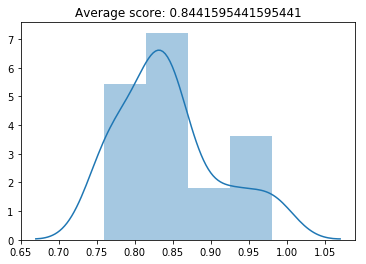

In [82]:
cv_scores = cross_val_score(clf, X_scaled, y, cv=10)
print(cv_scores)
sns.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

# GradientBoostingClassifier

Best score: 0.8333333333333334
Best parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 50}
              precision    recall  f1-score   support

           h       0.97      0.75      0.85        44
           p       0.76      0.97      0.85        36

   micro avg       0.85      0.85      0.85        80
   macro avg       0.87      0.86      0.85        80
weighted avg       0.88      0.85      0.85        80

Accuracy test score: 0.85


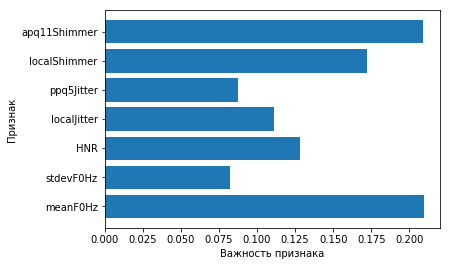

In [98]:
from sklearn.ensemble import GradientBoostingClassifier

GB = GradientBoostingClassifier(random_state = 12)
params = {'learning_rate':[0.1,0.2,0.3, 0.4, 0.5],'n_estimators':[4,8,12,24,34,50], 'max_depth':[1,2,3,4,5]}
clf = GridSearchCV(GB,params,cv=10)
clf.fit(X_train, y_train)
print("Best score:", clf.best_score_)
print("Best parameters:", clf.best_params_)
clf = clf.best_estimator_

def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X.iloc[:])
    plt.xlabel("Важность признака")
    plt.ylabel("Признак")
plot_feature_importances(clf)
print(classification_report(y_test,clf.predict(X_test)))
print('Accuracy test score:', accuracy_score(y_test,clf.predict(X_test)))

[0.92592593 0.88888889 0.90740741 0.94444444 0.88888889 0.92592593
 0.92307692 0.88461538 0.82692308 0.94230769]


Text(0.5, 1.0, 'Average score: 0.9058404558404558')

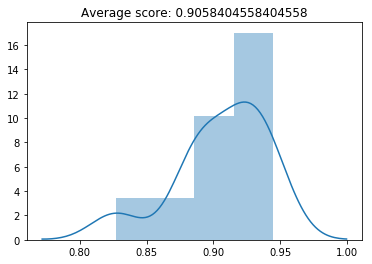

In [99]:
cv_scores = cross_val_score(clf, X, y, cv=10)
print(cv_scores)
sns.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

## Saving Classifier

In [102]:
import pickle
pickle.dump(clf, open('GB_model.sav','wb'))

In [103]:
clf = pickle.load(open('GradientBoosting_model.sav','rb'))
arr = np.array([1,1,5,0.1,0.6,1,7])
print(arr.shape)
print("Dysphonic probability:", round(clf.predict_proba([arr])[:,1][0]*100,1),'%')

(7,)
Dysphonic probability: 98.1 %
